## Loading Libraries

In [2]:
!pip install h3
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import h3
import folium
from datetime import datetime

## Loading and exploring datasets

### Data Orders CSV file

In [13]:
orders = pd.read_csv("data_orders.csv")
orders.head(10)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
5,21:21:23,-0.947011,51.456380,NaN,3000583117054,9,0,NaN
6,07:58:15,-0.955637,51.470372,NaN,3000582791789,9,0,NaN
7,07:53:46,-0.978230,51.454575,NaN,3000582791562,9,0,NaN
8,08:53:01,-1.052298,51.454308,NaN,3000582817606,9,0,NaN
9,06:33:52,-0.976216,51.433202,NaN,3000582765616,4,0,78.0


Exploring number of null values in each columns. This information might be necessary for future questions that require data cleaning. Depending on the complexity of the data and scope, we may either replace these null values with the 'most frquent' value or the 'average' value. This would depend on whether the values in the column are integers or string values.

In [27]:
print(f"Shape of orders dataset: {orders.shape}")
orders.isna().sum()
orders.isna().sum()/orders.shape[0]

Shape of orders dataset: (10716, 8)


order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
Order Status                     0.000000
Driver Assignment                0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

We can see that the number of null values come out to be 74% of the data but before we diecide what to do with the null values, we should trasnform the data to better fit our understanding. For example, convert 4 to client cancellation and 1 to 'Yes' for driver assignment. A quick little .info() fucntion to extract data types of each columns. 

In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [16]:
status_key = {4:'client cancellation', 9:'system cancellation'}
driver_assignment_key = {0:'No', 1:'Yes'}

orders['order_status_key'] = orders['order_status_key'].replace(status_key)
orders['is_driver_assigned_key'] = orders['is_driver_assigned_key'].replace(driver_assignment_key)

orders = orders.rename(columns = {'is_driver_assigned_key':'Driver Assignment', 'order_status_key':'Order Status'})

orders.head(10)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,Order Status,Driver Assignment,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,client cancellation,Yes,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancellation,No,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancellation,Yes,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,client cancellation,Yes,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,system cancellation,No,NaN
5,21:21:23,-0.947011,51.456380,NaN,3000583117054,system cancellation,No,NaN
6,07:58:15,-0.955637,51.470372,NaN,3000582791789,system cancellation,No,NaN
7,07:53:46,-0.978230,51.454575,NaN,3000582791562,system cancellation,No,NaN
8,08:53:01,-1.052298,51.454308,NaN,3000582817606,system cancellation,No,NaN
9,06:33:52,-0.976216,51.433202,NaN,3000582765616,client cancellation,No,78.0


In [36]:
orders['Order Status'].count()

np.int64(10716)

### Data Offers CSV file

In [28]:
offers = pd.read_csv('data_offers.csv')
offers.head(10)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196
5,3000589281354,300051262015
6,3000589106142,300051250324
7,3000622819913,300051794962
8,3000630156692,300052288434
9,3000630781485,300052318376


In [29]:
offers.isna().sum()

order_gk    0
offer_id    0
dtype: int64

In [30]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


## Merging Offer data and Order data together on 'order_gk' column

In [41]:
gett_data = orders.merge(right = offers, how = 'inner', on = 'order_gk', )
gett_data.head(10)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,Order Status,Driver Assignment,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,client cancellation,Yes,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancellation,No,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancellation,No,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,client cancellation,No,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancellation,Yes,46.0,300050976275
5,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancellation,Yes,46.0,300050976284
6,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancellation,Yes,46.0,300050976283
7,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancellation,Yes,46.0,300050976271
8,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancellation,Yes,46.0,300050976274
9,12:07:50,-0.969520,51.455544,477.0,3000582891479,client cancellation,Yes,46.0,300050976278


In [42]:
gett_data['Order Status'].value_counts()

Order Status
client cancellation    21795
system cancellation     9473
Name: count, dtype: int64

## Question 1

Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot, Which category has the highest number of orders?

    -- Creating a pivot table to group by reasons for failure before and after driver assignment. 

In [53]:
gett_pivot = pd.pivot_table(data = gett_data, columns = ['Driver Assignment', 'Order Status'], values = ['order_gk'], aggfunc = 'count')
gett_pivot.head(10)

Driver Assignment                  No                                     Yes  \
Order Status      client cancellation system cancellation client cancellation   
order_gk                        13435                9469                8360   

Driver Assignment                      
Order Status      system cancellation  
order_gk                            4

In [60]:
gett_pivot['No']

Order Status,client cancellation,system cancellation
order_gk,13435,9469


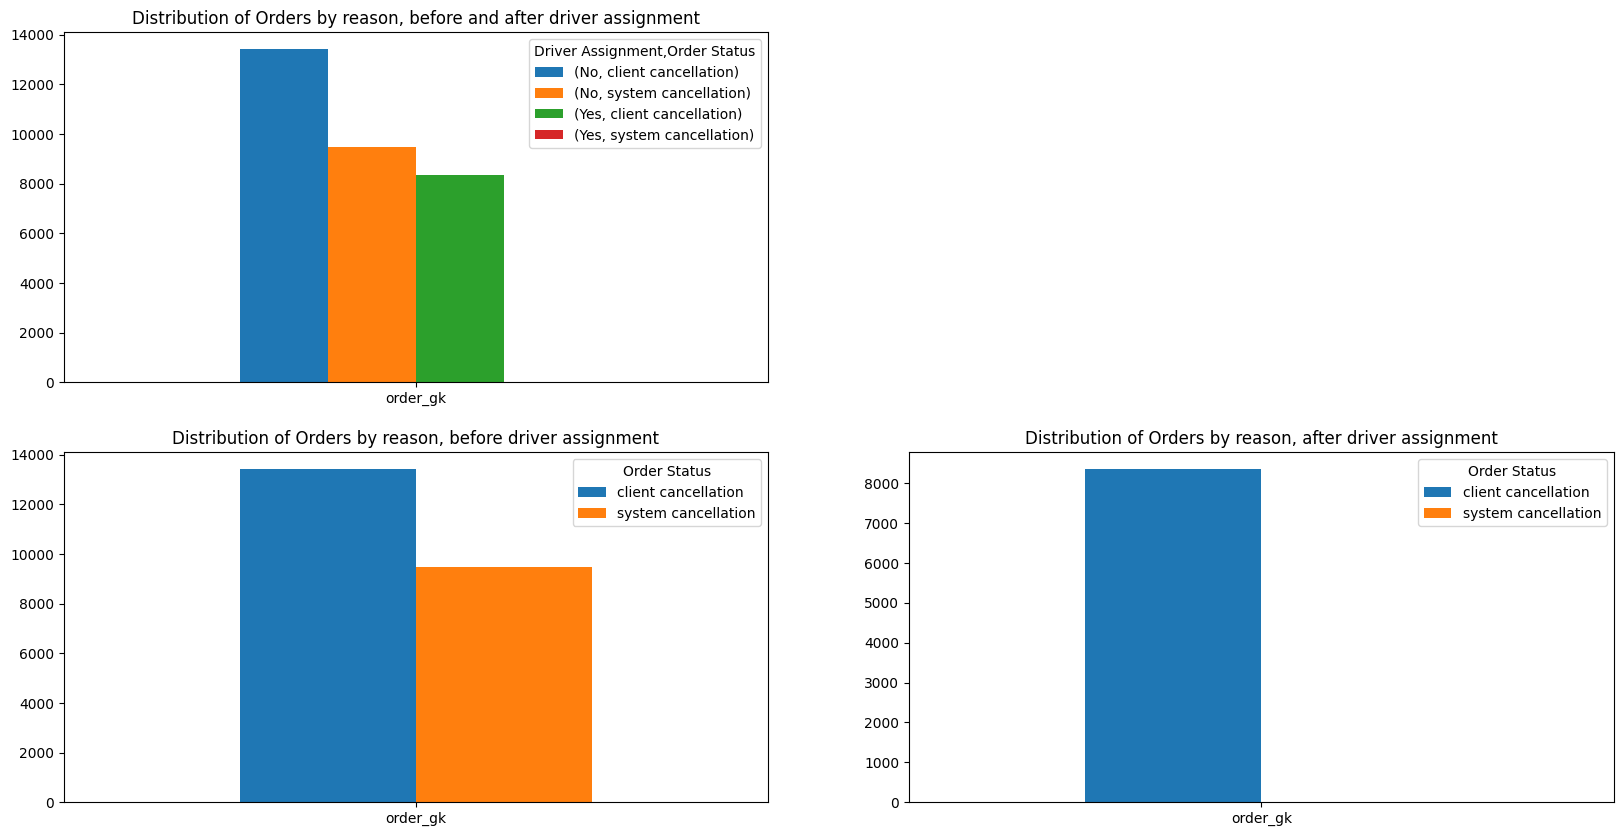

In [76]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
gett_pivot.plot(kind = 'bar', subplots=False, legend = True, rot = 0, ax = ax[0,0]).set_title('Distribution of Orders by reason, before and after driver assignment')
gett_pivot["No"].plot(kind = 'bar', subplots=False, legend = True, rot = 0, ax = ax[1,0]).set_title('Distribution of Orders by reason, before driver assignment')
gett_pivot["Yes"].plot(kind = 'bar', subplots=False, legend = True, rot = 0, ax = ax[1, 1]).set_title('Distribution of Orders by reason, after driver assignment')
ax[0, 1].axis('off')

plt.show()

We can see that the majority of the cancellations happen before drivers are assigned. With respect to client cancellation, we can see that the cancellations usually happens before a driver is assigned. This could be due to a penalty fee customers may have to pay if they cancelled the drive after a driver is assigned. With system cancellations, a majority of these calculations are done before driver assignment. This could be due to timeout errors or rejection of credit card information. The pivot table shows us that there are 4 system cancellations that happen after drivers have been assigned. These system cancellations are likely a direct correlation with drivers cancelling rides. 